# Intro into tensorflow

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float64')
tf.__version__

'2.3.1'

## Preprocessing Data
Let's start with loading the california housing dataset

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

We first do a train-test split

In [3]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [4]:
X_train.shape

(11610, 8)

Let's look at the data. We have 8 features.

In [5]:
X_train[0]

array([ 2.08850000e+00,  3.50000000e+01,  4.81206497e+00,  1.10672854e+00,
        1.68700000e+03,  3.91415313e+00,  3.76200000e+01, -1.21010000e+02])

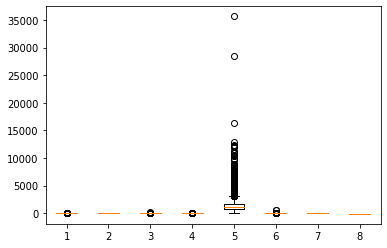

In [6]:
plt.boxplot(X_train);

The X is obviously not scaled. The y seems to be scaled.

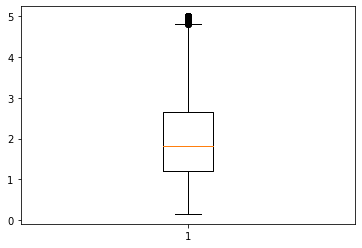

In [7]:
plt.boxplot(y_train);

So we start with scaling.

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

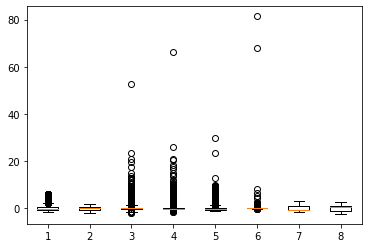

In [9]:
plt.boxplot(X_train);

Now, the data is ready for the model. IRL, you might want to check the outlier on feature 6, but for now, we just trust the dataset because we downloaded it as an example...

# Building a first model
We will start with a simple dense layer.

In [10]:
from tensorflow.keras.layers import Dense

First, have a look at the first observation with 8 features.

In [11]:
X_train[0]

array([-0.94393986,  0.50411416, -0.25654026,  0.015753  ,  0.23300133,
        0.11837028,  0.93475614, -0.71939969])


## Functional API
Now, we let this flow through a first layer of 30 neurons. The style `x = Dense(1)(x)` is called the functional API. We will see that we have other options, too.

In [12]:
x = Dense(30)(X_train)
X_train.shape, x.shape

((11610, 8), TensorShape([11610, 30]))

As you can see, we had about 11k observations, with 8 featurs. The dense layers pulls that through a first layer of nodes. We end with 30 features. Let's have a look at the first observation:

In [13]:
x[0]

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([-0.2031918 ,  0.14733529,  0.12262308,  0.31602677, -0.21024721,
       -0.41488809, -0.32296975, -0.41714651, -0.1687858 , -0.13174773,
       -0.20900778, -0.0824748 ,  0.30254124, -0.5320922 , -0.20213388,
       -0.51637692,  0.3335009 , -0.62555716,  0.41458903, -0.22263328,
        0.30134248,  0.34940347,  0.06791184,  0.20219211, -0.28104394,
        0.00290496, -0.5631028 ,  0.22420491, -0.66816245, -0.10769569])>

Of course, this Dense layers is using random weights, because it has not learned anything yet. This is just to show you that it works.

Because we want the outcome to be a single number, we feed the output of that layer into a next layer with just one neuron.

In [14]:
x = Dense(1)(x)
x[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.32209128])>

Note how the Dense layer handles 2D matrices.. If we have a 100 observations, each a 10x10 matrix, this happens:

In [15]:
import numpy as np
m = np.ones((100, 10,10))
m = Dense(1)(m)
m.shape

TensorShape([100, 10, 1])

We now have 100 observations, each a 10x1 matrix. While that might be what you want, that chance is much bigger that you want something like this:

In [16]:
from tensorflow.keras.layers import Flatten
m = np.ones((100, 10,10))
m = Flatten()(m)
print("after flatten shape:", m.shape)
m = Dense(1)(m)
print("after Dense shape:",m.shape)

after flatten shape: (100, 100)
after Dense shape: (100, 1)


The `Flatten()` layer changes every 10x10 observation into a vector of length 100.
This vector is passed on to a Dense layer with just one node (`Dense(1)`), and thus outputs just one number for every observation. 

If you change the amount of nodes in the dense layer from 1 to some other number (eg `Dense(10)`), that other number will be the new vector-length the layer outputs.

So, while we have a calculation running with 
```
x = Dense(30)(X_train)
x = Dense(1)(x)
```

We don't have a proper model yet. To do that, we have multiple options. In the functional API, we can create a model like this:

In [17]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
input = Input(shape=X_train.shape[1:])
x = Dense(30)(input)
output = Dense(1)(x)

model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


Note a few things:

1. We specify the input shape while removing the first number with an `Input()` layer. The first number we remove is the amount of observations we have. The shape of a single instance of trainingdata is a vector of size 8. So we use `X.shape[1:]`
2. The flow of information goes from right to left. `input` goes through the first `Dense(30)` layer, resulting in x, which is the input for the next `Dense(1)` layer.
3. While specifying the model, we need to specify the inputs and outputs as a list, even though we have just one item.

We start with 8 features, and end with a single prediction. 

## Sequential API
Another way to stitch this together is with the Sequential API.

In [18]:
from tensorflow.keras.models import Sequential
model = Sequential([
    Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


While the models are equivalent, you can do things with the Functional API that you can't do with the Sequential API (like defining multiple inputs and outputs). However, usually, the Sequential is just fine and is a little bit easier to set up.

In both the Sequential and Functional case, we end up with a model that we will need to compile.

When we do that, we specifying a loss (in this case, Mean Square Error) and an optimizer (Stochastic Gradient Descent). We can also add additional metrics, in this case, a Mean Absolute Error and Mean Absolute Percentage Error. You can find an overview of all losses in the [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

In [19]:
model.compile(loss="mse", optimizer='sgd', metrics=['mae', 'mape'])

And with this, we can start the learning. Let's do this for 20 epochs (rounds of learning).

In [20]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.1709 - mae: 0.6510 - mape: 38.1808 - val_loss: 0.5305 - val_mae: 0.5278 - val_mape: 30.4559
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4613 - mae: 0.4906 - mape: 28.6328 - val_loss: 0.4471 - val_mae: 0.4702 - val_mape: 25.9183
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4184 - mae: 0.4641 - mape: 26.3954 - val_loss: 0.4260 - val_mae: 0.4620 - val_mape: 25.9205
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4245 - mae: 0.4591 - mape: 26.1466 - val_loss: 0.4171 - val_mae: 0.4536 - val_mape: 24.9571
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3942 - mae: 0.4469 - mape: 25.4517 - val_loss: 0.4006 - val_mae: 0.4451 - val_mape: 24.6039
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3897 - mae: 0.4444 - mape: 25.3151 - val_loss: 0.3987 - val_mae: 0.4399 - val_mape: 

We can see the loss drop, as well as the validation loss. This learning process can be easily visualized.

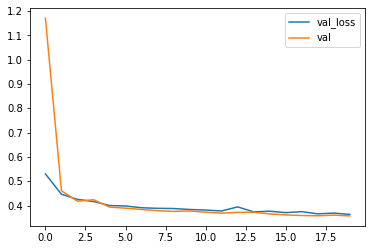

In [21]:
import matplotlib.pyplot as plt 
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='val')
plt.legend()

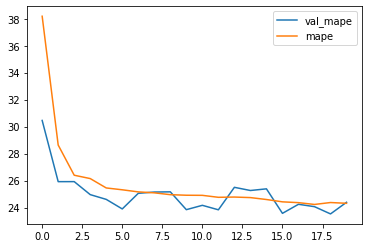

In [22]:
plt.plot(history.history['val_mape'], label='val_mape')
plt.plot(history.history['mape'], label='mape')
plt.legend()

And we can make predictions, or evaluate with the testset.

In [23]:
yhat = model.predict(X_test)
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 896us/step - loss: 0.3547 - mae: 0.4198 - mape: 24.3937


[0.35473832349444545, 0.41980977252280016, 24.393748951128384]

# Other network shapes
We saw networks with a singel input and output. But sometimes you would want to have more then one input, or output. That can be done with the Functional API:

In [24]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
input1 = Input(shape=X_train.shape[1:])
input2 = Input(shape=X_train.shape[1:])
x1 = Dense(30)(input1)
x2 = Dense(30)(input2)
x = tf.concat([x1, x2], 1)
output = Dense(1)(x)

model = Model(inputs=[input1, input2], outputs=[output])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           270         input_3[0][0]                    
_______________________________________________________________________________________

Here, we created two inputs, each going into their own `Dense(30)` layer. That outputs a vector of length 30. The outputs are concatenated into a vector of lengthe 60, and fed into a `Dense(1)` layer. Let's say we want to output the x layer in an earlier stage, that can be done like this:

In [25]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
input1 = Input(shape=X_train.shape[1:])
input2 = Input(shape=X_train.shape[1:])
x1 = Dense(30)(input1)
x2 = Dense(30)(input2)
x = tf.concat([x1, x2], 1)
early_output = Dense(1)(x)
x = Dense(30)(x)
x = Dense(30)(x)
output = Dense(1)(x)

model = Model(inputs=[input1, input2], outputs=[output, early_output])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 30)           270         input_4[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 30)           270         input_5[0][0]                    
_______________________________________________________________________________________

Note, that Tensorflow will use the same loss function for both outputs. If you dont want that, you will need to specify multiple losses, and if you don't want the losses to be added, you should add weights too.

In [26]:
model.compile(loss=['mape', 'mse'], loss_weights=[0.9, 0.1])

In this example, the `output` has a `mape` loss, the `early_output` an `mse` loss. The first one is weighted 0.9, the second one 0.1.

# Finetuning hyperparameters 
But creating a network is something that needs many iterations, normally. So, we would want to keep track of all the changes we make, and to compare them. Having to create matplotlib plots is not the best way to do that. We will use tensorboard to keep track. In addition, we want don't want to stop to soon, but we also want to avoid overfitting by training too long. Earlystopping is an easy way to do so.

In [27]:
%load_ext tensorboard
import datetime
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
#!rm -rf logs/ #this cleansup the logsdir on UNIX systems (e.g. non windows systems)

In [28]:
tf.random.set_seed(42)
log_dir = "logs/fit/" + "single_layer"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Sequential([
    Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    Dense(1)
])
model.compile(loss="mse", optimizer='sgd')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback, early_stop], verbose = 0)
model.evaluate(X_test, y_test)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
162/162 [==============================] - 0s 798us/step - loss: 0.3166


0.31660025503284245

Usually, I would advise to use tensorboard.

There are multiple ways to open this.
## locally
1. If you run it locally, you can easily open it from inside the jupyter notebook with `%tensorboard --logdir /logs/fit`
2. If you don't run it inside a browser, but in VS code, will probably need to specify the host and port. `%tensorboard --logdir=./logs/fit --host localhost --port 6006`. You can then start a browser and go to http://localhost:6006

## jupyterhub
On the jupyterhub, it is possible to open a tensorboad, but only with tensorflow 2.1.0. While we could downgrade, this breaks the keras-tuner we will be using later on in this notebook. While tensorboard is really preferable to matplotlib, we will have to work around that on the jupyterhub. I created a `plot_result` function as a workaround.

In [29]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_results(result, ymin= 0, ymax=None, yscale='linear', moving=None, alpha=0.5):
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    move = type(moving) == int

    for key in result.keys():
        loss = result[key].history['loss']
        if (move):
            z = movingaverage(loss, moving)
            z = np.concatenate([[np.nan]*moving, z[moving:-moving]])
            color = next(ax1._get_lines.prop_cycler)['color']
            ax1.plot(z, label = key, color = color)
            ax1.plot(loss, label = key, alpha = alpha, color=color)
        else:
            ax1.plot(loss, label = key)
        
        ax1.set_yscale(yscale)
        ax1.set_ylim(ymin, ymax)
        ax1.set_title('train')    

        valloss = result[key].history['val_loss']
        
        if (move):
            z = movingaverage(valloss, moving)
            z = np.concatenate([[np.nan]*moving, z[moving:-moving]])
            color = next(ax2._get_lines.prop_cycler)['color']
            ax2.plot(z, label = key, color=color)
            ax2.plot(valloss, label = key, alpha = alpha, color=color)
        else:
            ax2.plot(valloss, label = key)
   
        ax2.set_yscale(yscale)
        ax2.set_ylim(ymin, ymax)
        ax2.set_title('test')
    
    plt.legend()
   

In [30]:
result = {}
result['single_layer'] = history

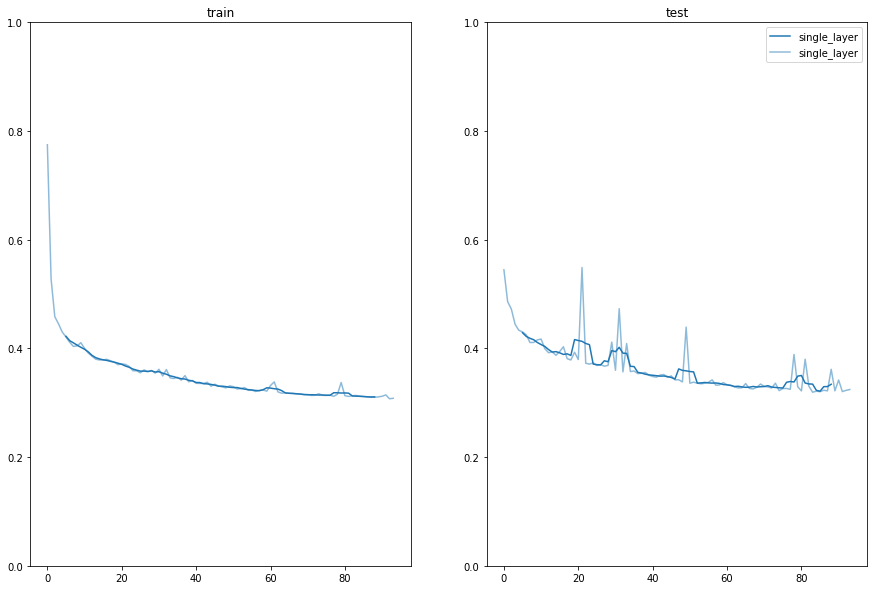

In [31]:
plot_results(result, ymax = 1, yscale='linear', moving = 5)

In [32]:
# Let;s try to improve the result. Maybe more layers? Let's add three.
tf.random.set_seed(42)
log_dir = "logs/fit/" + "three_layers"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model = Sequential([
    Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(1)
])
model.compile(loss="mse", optimizer='sgd')
result['three_layers'] = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 856us/step - loss: 0.2885


0.2884526765161706

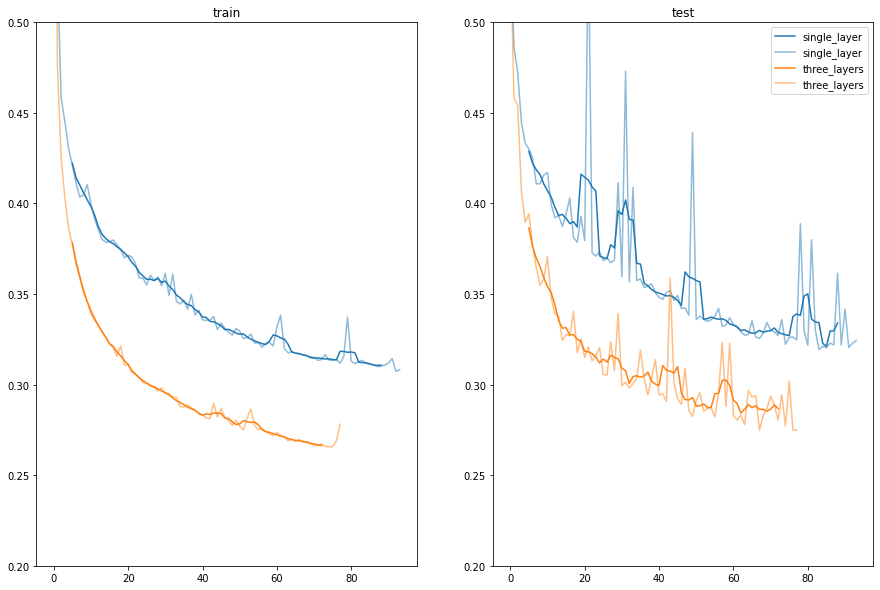

In [33]:
plot_results(result, ymin=0.2, ymax=0.5, moving=5)

That seems to be working better. It trains faster, and more accurate. Now add momentum to the SGD

In [34]:
tf.random.set_seed(42)
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)

log_dir = "logs/fit/" + "momentum"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = Sequential([
    Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(1)
])
model.compile(loss="mse", optimizer=optimizer)
result['momentum'] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
model.evaluate(X_test, y_test)


162/162 [==============================] - 0s 877us/step - loss: 0.2819


0.28188446173372195

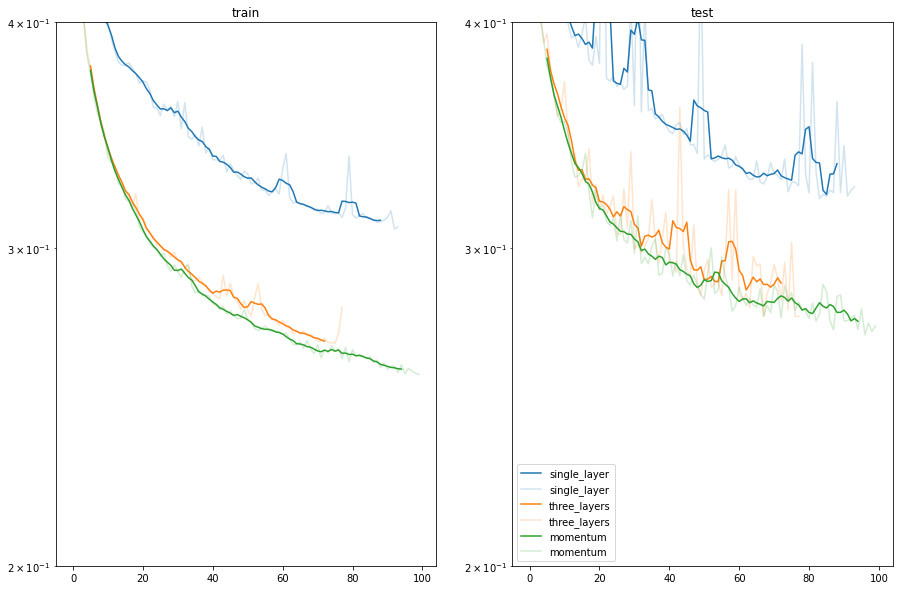

In [35]:
plot_results(result,ymin=0.2,  ymax = 0.4, yscale='log', moving=5, alpha=0.2)

It's just a little bit better, but not much. Now compare that to Adam

In [36]:
tf.random.set_seed(42)
log_dir = "logs/fit/" + "Adam"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = Sequential([
    Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam())
result['Adam'] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 823us/step - loss: 0.2735


0.2734650430291198

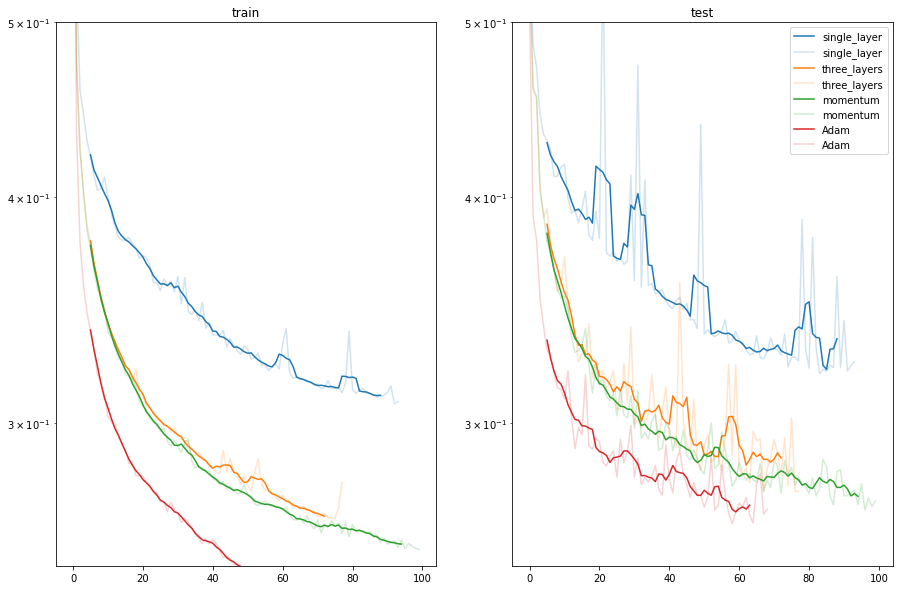

In [37]:
plot_results(result,ymin=0.25,  ymax = 0.5, yscale='log', moving=5, alpha=0.2)

This is even better.

# Hyperparameter tuning
While it is really usefull to play with different architectures to see what happens, it can easily become very time consuming. Right now, we are just considering Dense layers, but we can add all sorts of layers in different combinations. The search-space is also much too big for a dumb gridsearch. Especially if we are going to add in more types of layers, each with their own parameters.

To do this more intelligent, we will use kerastuner. This implements smart ways to sample the hyperparameter space.


We will define ranges of hyperparameters. All the different types can be find in the [keras documentation](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/).

First, we set the range of the amount of units in every dense layer to somewhere between 32 an 96, in steps of 32.
Second, we add a for loop to add multiple dense layers, somewhere between 2 and 5 additional layers.

In [38]:
from tensorflow.keras.layers import Input

def build_model(hp):
    input = Input(shape = X_train.shape[1:])

    units = hp.Int('units', 32, 128, 32)
    #act = hp.Choice('activation', ['relu', 'elu'])
    act='relu'
    x = Dense(units, activation=act)(input)

    for i in range(hp.Int('dense_layers', 2, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation=act)(x)
    
    output = Dense(1)(x)
    model = keras.Model(inputs = [input], outputs = [output])
    model.compile(loss="mse", optimizer=keras.optimizers.Adam())
    return model

The [hyperband algorithm](https://jmlr.org/papers/v18/16-558.html) (image (b), configuration selection) often outperforms bayesian search (image (a), Configuration selection), at least in speed. However, according to the [No Free Lunch Theorem](https://ti.arc.nasa.gov/m/profile/dhw/papers/78.pdf) "for any algorithm, any elevated performance over one class of problems is offset by performance over another class". So, as a rule of thumb, use Hyperband, but there is no guarantee that you get the best results. We set the max_epochs low, to speed things up. We might get better results by increasing that number some, but for this tutorial it will take too long. And we can still get an improvement over what we had.

<img src="hyperband.png">

In [39]:
%%time
import kerastuner as kt
# cleaning up folders from old runs
!rm -rf ktuner 

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    factor=3,
    directory='ktuner',
    project_name='housing',

)

tuner.search(X_train, y_train, epochs = 15, validation_data = (X_valid, y_valid))

Trial 10 Complete [00h 00m 05s]
val_loss: 0.3069583967366576

Best val_loss So Far: 0.29970891825296464
Total elapsed time: 00h 00m 30s
INFO:tensorflow:Oracle triggered exit
CPU times: user 46 s, sys: 9.9 s, total: 55.9 s
Wall time: 31 s


Note that the CPU time is about a minute in total. We can obtain the best values from the search:

In [40]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'units': 96,
 'dense_layers': 3,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

And the best model.

In [41]:
model = tuner.get_best_models()[0]
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 96)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
Total params: 28,897
Trainable params: 28,897
Non-trainable params: 0
__________________________________________________

And train that.

In [42]:
%%time
tf.random.set_seed(42)
log_dir = "logs/fit/" + "hyperband"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback, early_stop], verbose = 0)
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 957us/step - loss: 0.2664
CPU times: user 45.3 s, sys: 10.8 s, total: 56.1 s
Wall time: 27.1 s


0.2664231980031775

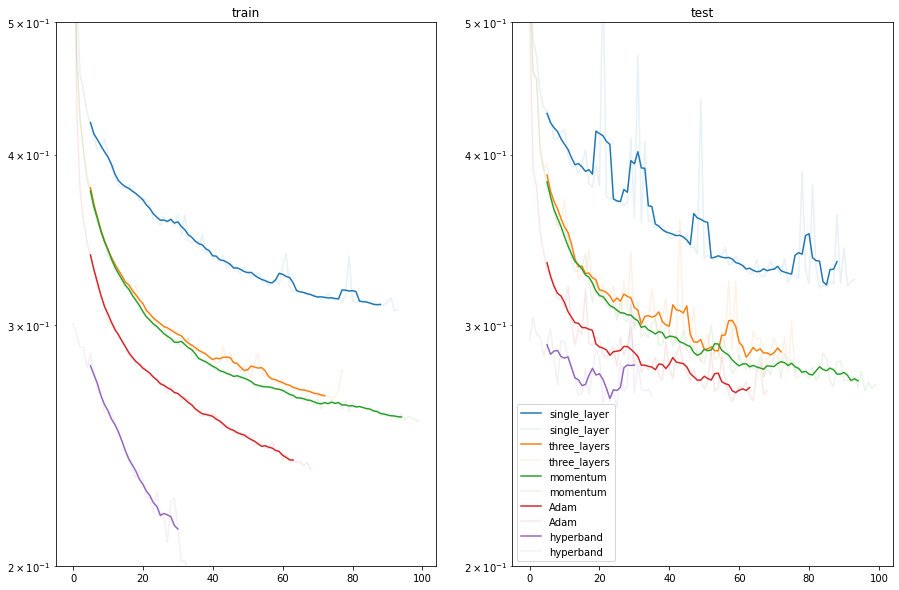

In [43]:
result['hyperband'] = history
plot_results(result, ymin=0.2, ymax = 0.5, yscale='log', moving=5, alpha=0.1)

Again, better results.

In [44]:
%%time
# cleaning up folders from old runs
!rm -rf ktuner 

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials = 10,
    directory='ktuner',
    project_name='housing',

)
tuner.search(X_train, y_train, epochs = 3, validation_data = (X_valid, y_valid))

Trial 10 Complete [00h 00m 03s]
val_loss: 0.34060256883155465

Best val_loss So Far: 0.34060256883155465
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1min, sys: 12.9 s, total: 1min 13s
Wall time: 38.3 s


Note how we do 10 trails, with max 3 epochs. We explore fewer options that with Hyperband, but have a longer walltime. This is a main reason to prefer Hyperband: in less time, you can explore more. 

Again, we can have a look at the best parameters

In [45]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'units': 96, 'dense_layers': 3}

Or obtain the best model

In [46]:
model = tuner.get_best_models()[0]
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 96)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
Total params: 28,897
Trainable params: 28,897
Non-trainable params: 0
__________________________________________________

With this reasonable small searchspace, the two approaches will find more or less the same architecture. However, if the searchspace is really big, hyperband will explore more of that space in less time.

In [47]:
%%time
log_dir = "logs/fit/" + "bayesian"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 950us/step - loss: 0.2695
CPU times: user 31.8 s, sys: 7.18 s, total: 38.9 s
Wall time: 18 s


0.2694808684116186

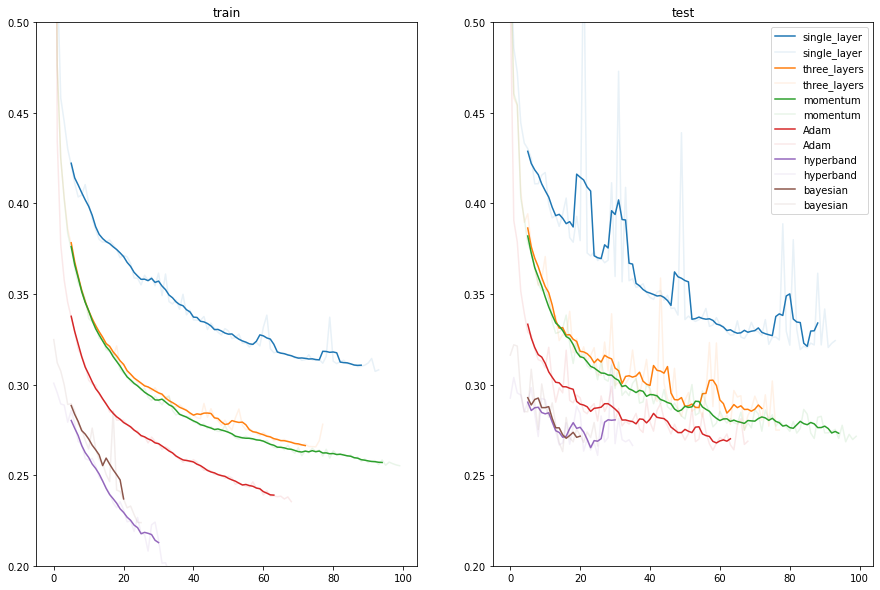

In [48]:
result['bayesian'] = history
plot_results(result, ymin=0.2, ymax=0.5, moving=5, alpha=0.1)

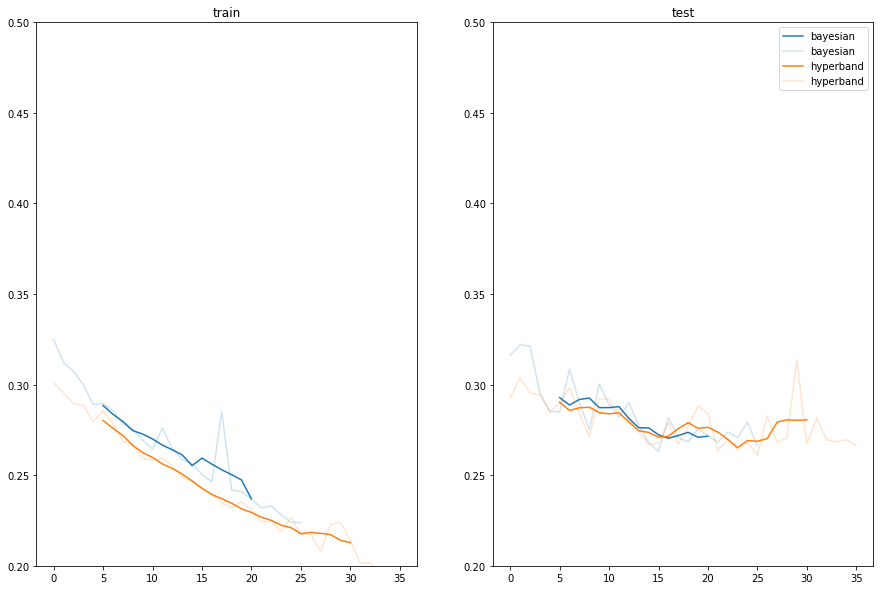

In [49]:
tuner_result = {x: result[x] for x in ['bayesian', 'hyperband']}
plot_results(tuner_result, ymin=0.2, ymax=0.5, moving=5, alpha=0.2)